# Efficient and Scalable Tool Usage for LLM Agents

O artigo apresenta uma abordagem diferente para Agentes de LLM, utilizando o princípio de **SLA** (Single Level of Abstraction) para diminuir suas latências e custos, permitindo que sejam mais eficientes e escalonáveis.

---

Agentes podem ser utilizados para tomadas de decisões, tornando-os capazes de resolver tarefas complexas.
Porém, agentes consomem muitos tokens, podendo aumentar os custos e a latência, uma vez que requerem pelo menos o dobro do uso de tokens comparado com um chat simples.

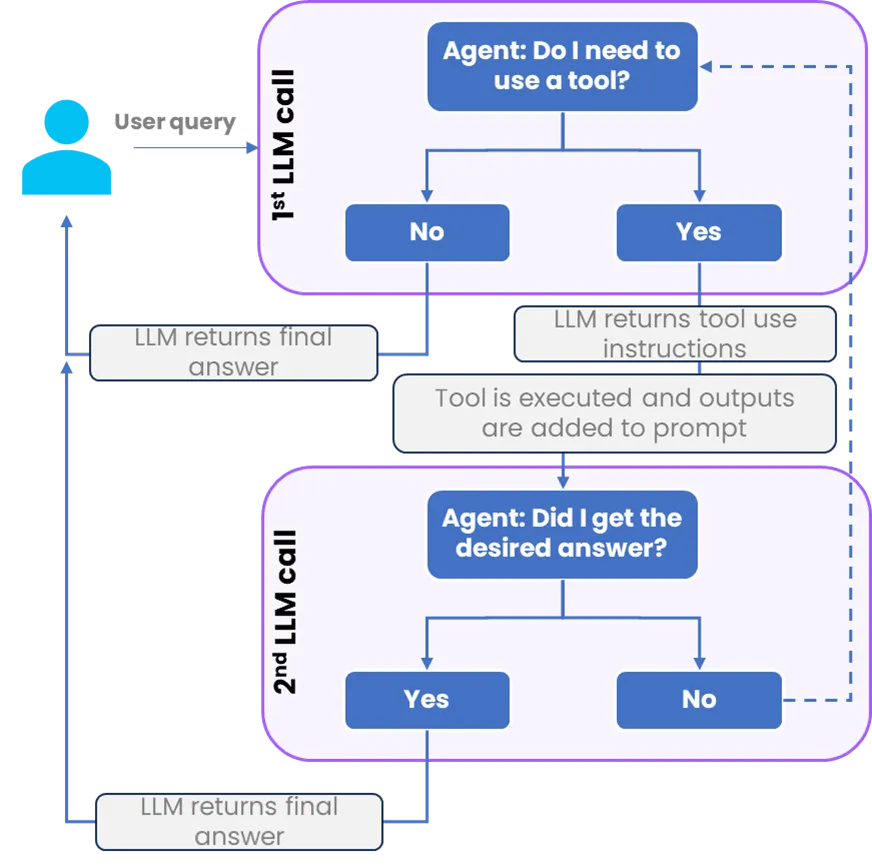

Utilizando o princípio de **Single Level Abstraction** (SLA), é possível separar os estágios de decisão e execução, garantindo uma melhor performance e escalabilidade. Dessa forma, ao invés de utilizar um único grande prompt, pode-se realizar várias chamadas à LLM em camadas.


*   **Agente de decisão**: apresenta diretrizes gerais sobre as próximas etapas que podem ser tomadas e como resumir os resultados da ferramenta para a resposta final voltada para o usuário
*   **Chats de execução**: apresenta instruções detalhadas sobre etapas específicas




In [ ]:
# LangChain
!pip install langchain -q U
!pip install langchain-community
!pip install -qU langchain-openai
!pip install -U langsmith

In [ ]:
from langchain import hub
from langchain.agents import AgentExecutor, create_json_chat_agent
from langchain.chat_models import ChatOpenAI
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import StructuredTool
from langchain.tools.render import render_text_description
import os
from typing import Optional
from google.colab import userdata

[LangSmith Prompt](https://smith.langchain.com/hub/hwchase17/react-json)

In [ ]:
# Setup your llm model
os.environ["OPENAI_API_KEY"] = userdata.get('OPEN_AI_KEY')
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_KEY')

llm = ChatOpenAI(temperature=0,  model="gpt-4-turbo-preview", streaming=True)

# Get the prompt to use - you can modify this!
prompt = hub.pull("hwchase17/react-chat-json")


/usr/local/lib/python3.10/dist-packages/langsmith/client.py:312: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [ ]:
class ApiParams(BaseModel):

    price: Optional[dict] = Field(description="total price of the flat in PLN for sale offers or total monthly costs for rent offers, min and/or max range.")

    rooms_num: Optional[dict] = Field(description="number of rooms,  min and/or max range")

    area: Optional[dict] = Field(description="area of flat in metres squared,  min and/or max range")

    rent_or_buy: Optional[str] = Field(description="Pay attention to requirements and choose if user is looking to rent or buy a flat. Allowed values ‘buy’, ‘rent’")

    price_per_meter: Optional[dict] = Field(description="price of the flat in PLN per meter squared min and/or max range" )

    build_year: Optional[dict] = Field(description="year where building was constructed, min and/or max range")


def render_argument_docs(ApiParams):
    arguments_docs = []
    for field_name, field in ApiParams.__fields__.items():
        doc_line = f"{field} description={field.field_info.description}"
        doc_line = doc_line.replace("default=None", "")
        arguments_docs.append(doc_line)

    arguments_docs = "\n\n".join(arguments_docs)
    return arguments_docs


def search_function(params):
    #Placeholder: actual api call should be placed here

    return "Found 42 offers with the following search filters:{params}"

offers_search_tool = StructuredTool.from_function(
    func = search_function,
    name = "offers_search",
    description=f"""
    To use this tool, prepare search filters based on description. Be precise and do not add filters, which are not clearly mentioned. \n
    Always provide filters as JSON. \n
    Here are the instructions of how to use each filters: {render_argument_docs(ApiParams)}.\n\n
    REMEMBER! Use only filters, which are clearly described in the input.
    """
)

tools = [offers_search_tool]

In [ ]:
import tiktoken

def num_tokens_from_string(string: str, model_name: str) -> int:
    try:
        encoding = tiktoken.encoding_for_model(model_name)
    except KeyError as e:
        raise KeyError(f"Error: No encoding available for the model '{model_name}'")
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [ ]:
tools_text = render_text_description(list(tools))
tools_tokens = num_tokens_from_string(tools_text, 'gpt-3.5-turbo')

In [ ]:
tools_tokens

266

In [ ]:
# Construct the JSON agent
agent = create_json_chat_agent(llm, tools, prompt)

# Create an agent executor by passing in the agent and tools
agent_executor = AgentExecutor(
    agent=agent, tools=tools, verbose=True, handle_parsing_errors=True
)

In [ ]:
result = agent_executor.invoke(
    {
        "input": "I am looking for a 2 room apartment for rent in Warsaw, my budget is 3000zł"
    }
)



> Entering new AgentExecutor chain...
```json
{
    "action": "offers_search",
    "action_input": "{\"rooms_num\": {\"min\": 2, \"max\": 2}, \"rent_or_buy\": \"rent\", \"price\": {\"max\": 3000}, \"area\": {\"min\": 0}}"
}
```Found 42 offers with the following search filters:{params}```json
{
    "action": "Final Answer",
    "action_input": "Based on the search, there are 42 offers for 2-room apartments for rent within your budget of 3000zł in Warsaw."
}
```

> Finished chain.


In [ ]:
result["output"]

'Based on the search, there are 42 offers for 2-room apartments for rent within your budget of 3000zł in Warsaw.'

**Exemplo** de ferramenta de busca preparada para um Agente de nível de Decisão.

Apresenta uma descrição breve e tudo que faz em execução é passar o input do usuário para outra chain. A última chain é onde todos os detalhes seriam adicionados

In [ ]:
def search_active_offers(user_input: str) -> dict:
    # Invoke the chain search offers function and extract parameters
    search_params = chain_search_offers.invoke({"input": user_input})
    return search_params


search_tool = StructuredTool.from_function(
    func=search_active_offers,
    name='offers_search_tool',
    description="""
    Use this tool to search for available offers based on description.
    In tool input provide a summarized description of what the user is looking for with as much detail as possible.
    The description should be in English. Pay attention to any details regarding desired location or districts.
    """
)